In [316]:
from copy import deepcopy

import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from arithmetic_lm.model import UniversalTransformer, generate
from arithmetic_lm.tokenizer import CharTokenizer
from arithmetic_lm.formatting import format_line

import warnings

warnings.filterwarnings("ignore")

In [2]:
ckpt_path = "../checkpoints/addition-1-9-digit-pad/ut_1steps_384embd_2head/step=15500-train_loss=0.0108-val_loss=4.6606.ckpt"

In [3]:
tokenizer = CharTokenizer()

In [173]:
# load model
ckpt = torch.load(ckpt_path, map_location="mps")
model = UniversalTransformer(
    **ckpt["hyper_parameters"]["model_hparams"], vocab_size=tokenizer.vocab_size
)
# state dict has a prefix "model." in the key names
model.load_state_dict({k[6:]: v for k, v in ckpt["state_dict"].items()})
model.eval()

UniversalTransformer(
  (embedding): Embedding(100, 384, padding_idx=99)
  (coord_encoder): CoordinateEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=384, out_features=384, bias=True)
    )
    (linear1): Linear(in_features=384, out_features=1536, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=1536, out_features=384, bias=True)
    (norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (decoder_layer): TransformerDecoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=384, out_features=384, bias=True)
    )
    (multihead_attn): MultiheadAttention(
      (out_proj): 

In [5]:
def eval_answer_addition(
    model,
    tokenizer,
    a: int,
    b: int,
    pad_zeros: int = 10,
    max_len: int = 11,
    verbose: bool = False,
) -> tuple[int, bool]:
    # compute real answer
    real_answer = a + b

    # prepare prompt
    prompt = f"\n${str(a).zfill(pad_zeros)}+{str(b).zfill(pad_zeros)}"
    if verbose:
        print(f"prompt: {prompt}")
    prompt = tokenizer.encode(prompt)
    prompt = torch.tensor(prompt)

    # generate
    out_ids = generate(
        model=model,
        idx=torch.tensor(tokenizer.encode("=")),
        max_new_tokens=max_len,
        encoder_source=prompt,
        stop_token=tokenizer.encode("$")[0],
    )
    out = tokenizer.decode(out_ids[0].tolist())
    if verbose:
        print(f"output: {out}")

    # extract answer
    pred_answer = int(out.replace("$", ""))
    return out, pred_answer == real_answer

In [6]:
a = 199999
b = 4562
out, correct = eval_answer_addition(
    model, tokenizer, a, b, pad_zeros=10, max_len=12, verbose=True
)
print(f"true answer: {a+b}")
print(f"correct: {correct}")

prompt: 
$0000199999+0000004562
output: 00000204561$
true answer: 204561
correct: True


## Evaluate different number of digits in operands

Model is trained on NxN (0-padded) addition, where both operands have the same number of digits. We evaluate the model on addition of two numbers with different number of digits (still padded to same length). 

In [7]:
# matrix of accuracy
max_digits = 10
n_samples_per_cell = 100
pad_zeros = 10

accuracy_matrix = np.zeros((max_digits, max_digits))
mistakes = []

for n_a in range(1, max_digits + 1):
    for n_b in range(1, max_digits + 1):
        correct = 0
        for _ in range(n_samples_per_cell):
            # generate random numbers
            a = np.random.randint(10 ** (n_a - 1), 10**n_a)
            b = np.random.randint(10 ** (n_b - 1), 10**n_b)
            _, is_correct = eval_answer_addition(
                model, tokenizer, a, b, pad_zeros=pad_zeros, max_len=12, verbose=False
            )
            # save mistakes
            if not is_correct:
                mistakes.append((a, b))
            correct += is_correct
        accuracy_matrix[n_a - 1, n_b - 1] = correct / n_samples_per_cell

print(accuracy_matrix)

[[1.   1.   1.   1.   1.   1.   1.   1.   0.98 0.  ]
 [1.   1.   1.   0.98 0.99 1.   1.   0.99 0.99 0.  ]
 [1.   1.   1.   1.   1.   0.99 0.98 0.97 1.   0.  ]
 [1.   1.   1.   1.   0.99 0.97 0.98 0.98 0.97 0.  ]
 [1.   1.   0.99 1.   0.99 0.97 1.   0.95 0.98 0.  ]
 [1.   1.   0.98 0.98 1.   0.98 0.97 0.97 0.97 0.  ]
 [0.99 0.99 1.   0.99 0.99 0.92 0.99 0.96 0.94 0.  ]
 [1.   1.   0.99 0.98 0.95 0.96 0.88 0.6  0.98 0.01]
 [0.97 0.96 0.94 0.95 0.92 0.95 0.96 0.83 0.98 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.09]]


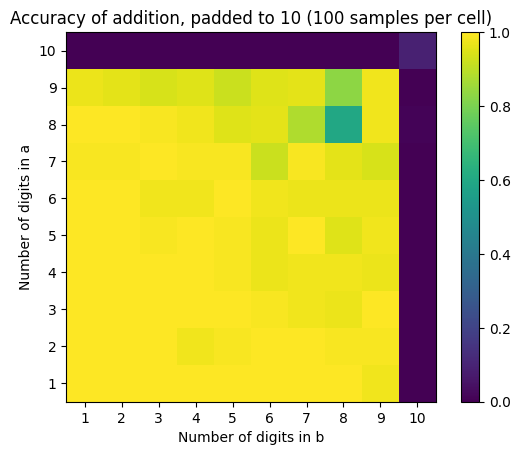

In [8]:
# plot accuracy matrix
plt.imshow(accuracy_matrix, cmap="viridis", interpolation="none")
plt.colorbar()
# set xtiks and yticks to be integers
plt.xticks(np.arange(max_digits), np.arange(1, max_digits + 1))
plt.yticks(np.arange(max_digits), np.arange(1, max_digits + 1))
plt.xlabel("Number of digits in b")
plt.ylabel("Number of digits in a")
plt.title(
    f"Accuracy of addition, padded to {pad_zeros} ({n_samples_per_cell} samples per cell)"
)
# invert y axis
plt.gca().invert_yaxis()
plt.show()

In [11]:
# print mistakes
for a, b in mistakes[-5:]:
    out, correct = eval_answer_addition(
        model, tokenizer, a, b, pad_zeros=pad_zeros, max_len=12, verbose=False
    )
    if not correct:
        n_a = len(str(a))
        n_b = len(str(b))
        out_int = int(out.replace("$", ""))
        n_true_ans = len(str(a + b))
        n_pred_ans = len(str(out_int))
        print(f"{a} + {b} = {a+b}")
        print(
            " " * (n_a + n_b + (n_true_ans - n_pred_ans))
            + f"pred: {out_int} ({out}) [{n_a}+{n_b} digit]"
        )
        print()

9666526984 + 9049891020 = 18716418004
                    pred: 88616418004 (88616418004$) [10+10 digit]

2454686047 + 8642336167 = 11097022214
                    pred: 11097022215 (11097022215$) [10+10 digit]

2634669234 + 1884757589 = 4519426823
                    pred: 1519426823 (01519426823$) [10+10 digit]

4920621115 + 9955806346 = 14876427461
                    pred: 44876427462 (44876427462$) [10+10 digit]

4540242457 + 4709173963 = 9249416420
                    pred: 1249416421 (01249416421$) [10+10 digit]



## Ablate residual stream of the encoder

In [159]:
eval("model.encoder_layer.self_attn", {"model": model})

MultiheadAttention(
  (out_proj): NonDynamicallyQuantizableLinear(in_features=384, out_features=384, bias=True)
)

In [415]:
def predict_with_hook(
    model: torch.nn.Module,
    prompt: torch.Tensor,
    decoder_prompt: torch.Tensor,
    hook: callable,
    hook_module: str,
) -> str:
    """
    Predict next token while ablating positions in the residual stream
    at the end of encoder. ablate_positions is a list of integers
    of positions in the sequence to set to zero.
    """

    hooked_model = deepcopy(model)
    hooked_model.eval()

    # hook
    # hooked_model.encoder_layer.register_forward_hook(hook)
    eval(
        f"hooked_model.{hook_module}", {"hooked_model": hooked_model}
    ).register_forward_hook(hook)

    logits = hooked_model(source=prompt, target=decoder_prompt)[0, -1, :]
    pred_token_id, pred_token_logit = logits.argmax().item(), logits.max().item()
    pred_token_str = tokenizer.decode([pred_token_id])

    # delete hooked model
    del hooked_model

    return pred_token_str, pred_token_logit

In [423]:
a = 1239999
b = 956959
pad_ans_zeros = 11

prompt_str = f"\n${str(a).zfill(pad_zeros)}+{str(b).zfill(pad_zeros)}"
print("prompt:", repr(prompt_str))
true_ans = a + b
print("true_ans:", true_ans)

# "fast-forward" to the first digit
decoder_prompt_str = "=" + "0" * (pad_ans_zeros - len(str(true_ans)))

# just before first actual digit
decoder_prompt = torch.tensor([tokenizer.encode(decoder_prompt_str)])
print(f"decoder prompt:", decoder_prompt_str)

prompt = tokenizer.encode(prompt_str)
prompt = torch.tensor([prompt])

# without ablation
logits = model(source=prompt, target=decoder_prompt)[0, -1, :]
pred_token = torch.argmax(logits).item()
pred_token_logit = logits.max().item()
print("pred_token_str:", tokenizer.decode([pred_token]), "logit:", pred_token_logit)


def mean_ablate_pos_in_res_stream(ablate_positions: list[int]):
    def hook_ablate(module, inputs, output):
        # set output to mean at ablated positions
        # output shape = [bs, seq_len, d_model]
        output[:, ablate_positions, :] = output.mean(dim=1, keepdim=True)
        return output

    return hook_ablate


# ablating digits
for i in range(prompt.shape[1]):
    pred_token_ablated, logit = predict_with_hook(
        model,
        prompt,
        decoder_prompt,
        mean_ablate_pos_in_res_stream([i]),
        "encoder_layer",
    )
    # str representation of ablation, set positions to '.'
    ablated_prompt_str = prompt_str[:i] + "." + prompt_str[i + 1 :]
    print(repr(ablated_prompt_str), pred_token_ablated, logit)


# ablating multiple digits
ablate_digits = list(range(0, 23))
pred_token_ablated, logit = predict_with_hook(
    model,
    prompt,
    decoder_prompt,
    mean_ablate_pos_in_res_stream(ablate_digits),
    "encoder_layer",
)
ablated_prompt_str = [
    "." if i in ablate_digits else c for i, c in enumerate(prompt_str)
]
ablated_prompt_str = "".join(ablated_prompt_str)
print(repr(ablated_prompt_str), pred_token_ablated, logit)

prompt: '\n$0001239999+0000956959'
true_ans: 2196958
decoder prompt: =0000
pred_token_str: 2 logit: 22.78687858581543
'.$0001239999+0000956959' 2 22.786880493164062
'\n.0001239999+0000956959' 2 22.786880493164062
'\n$.001239999+0000956959' 2 22.786882400512695
'\n$0.01239999+0000956959' 2 22.788240432739258
'\n$00.1239999+0000956959' 2 22.78998565673828
'\n$000.239999+0000956959' 2 22.417905807495117
'\n$0001.39999+0000956959' 2 22.958602905273438
'\n$00012.9999+0000956959' 2 22.822948455810547
'\n$000123.999+0000956959' 2 22.78687858581543
'\n$0001239.99+0000956959' 2 22.78687858581543
'\n$00012399.9+0000956959' 2 22.78687858581543
'\n$000123999.+0000956959' 2 22.78687858581543
'\n$0001239999.0000956959' 2 22.78687858581543
'\n$0001239999+.000956959' 2 22.786888122558594
'\n$0001239999+0.00956959' 2 22.787700653076172
'\n$0001239999+00.0956959' 2 22.794158935546875
'\n$0001239999+000.956959' 2 22.965877532958984
'\n$0001239999+0000.56959' 2 22.443578720092773
'\n$0001239999+00009.6959

Ablating residual stream even at most positions still recovers the answer. This suggests that the model moves information about the operands to other tokens after the first self-attention layer already. Is it possible that the MLP layer in the encoder and the rest i.e. decoder are doing addition by "lookup" in the d_model space? Can we extract something interesting from embeddings after the encoder?

## Linear probe on encoder embeddings

try to predict digits in the operands from the encoder embeddings linearly, if we can, then look at what directions in the embedding space encode what digits.

In [379]:
def accuracy(logits, target):
    pred_token = torch.argmax(logits, dim=1)
    return (pred_token == target).sum().item() / target.shape[0]

In [380]:
def train_linear_probe(
    embeddings: torch.Tensor,
    targets: torch.Tensor,
    i_token: int,
    i_pred_digit: int,
    n_epochs: int = 10,
    l1_reg: float = 0.0,
    l2_reg: float = 0.0,
):
    """
    embeddings: [n_samples, seq_len, d_model]
    targets: [n_samples, n_targets]
    """
    # train linear probe to predict operands (10 + 10 = 20 digits total)
    # so, 20 independent linears from 384 (d_model) to 10 (digits)
    i_token = 0  # index of token in sequence to use for prediction
    i_pred_digit = 0  # index of digit to predict

    embeddings = embeddings[:, i_token, :]  # shape [n_samples, d_model]
    targets = targets[:, i_pred_digit]  # shape [n_samples]

    # train linear probe with L1 norm on weights
    linear_probe = torch.nn.Linear(embeddings.shape[1], 10, bias=False)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(
        linear_probe.parameters(), lr=0.001, weight_decay=l2_reg
    )

    loss_history = []
    acc_history = []
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        preds = linear_probe(embeddings.detach())
        loss = criterion(preds, targets) + l1_reg * torch.norm(linear_probe.weight, p=1)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        acc_history.append(accuracy(preds, targets))

    return linear_probe, loss_history, acc_history

In [424]:
def compute_and_plot_acc_matrix(
    n_digits: int | tuple[int, int],
    n_samples: int,
    pad_zeros: int,
    pad_ans_zeros: int,
):
    # generate samples
    samples = []
    if isinstance(n_digits, int):
        n_digits = (n_digits, n_digits)
    for i in range(n_samples):
        a = np.random.randint(10 ** (n_digits[0] - 1), 10 ** n_digits[0])
        b = np.random.randint(10 ** (n_digits[1] - 1), 10 ** n_digits[1])
        samples.append(
            format_line(
                f"{a}+{b}={a+b}",
                pad="$",
                prepend_newline=True,
                pad_ops_zero=pad_zeros,
                pad_ans_zero=pad_ans_zeros,
            ).split("=")[
                0
            ]  # only encoder prompt
        )
    print(samples[:3])

    # get embeddings
    embeddings = []
    for sample in samples:
        prompt = tokenizer.encode(sample)
        prompt = torch.tensor([prompt])
        embeddings.append(model.encode(prompt))

    # get operands as targets
    targets = []
    for sample in samples:
        targets.append([int(c) for c in sample if c.isdigit()])
    targets = torch.tensor(targets)  # shape = [n_samples, n_digits]
    print("targets:", targets.shape, targets.dtype)

    embeddings = torch.cat(embeddings)
    print("embeddings:", embeddings.shape, embeddings.dtype)

    n_epochs = 20
    weights = np.empty(
        (embeddings.shape[1], 10, embeddings.shape[2])
    )  # linear probe weights from all tokens to all digits
    acc_matrix = np.empty((embeddings.shape[1], targets.shape[1]))
    for i_token in range(embeddings.shape[1]):
        for i_pred_digit in range(targets.shape[1]):
            linear_probe, loss_history, acc_history = train_linear_probe(
                embeddings,
                targets,
                i_token,
                i_pred_digit,
                n_epochs=n_epochs,
                l1_reg=1.0,
                l2_reg=0.0,
            )
            acc_matrix[i_token, i_pred_digit] = acc_history[-1]
            weights[i_token, ...] = linear_probe.weight.detach().numpy()

    plt.imshow(acc_matrix, cmap="viridis", interpolation="none", vmin=0, vmax=1)
    plt.colorbar()
    plt.xticks(np.arange(targets.shape[1]))
    plt.yticks(np.arange(embeddings.shape[1]))
    plt.xlabel("Predicted operand digit index")
    plt.ylabel("Embedding token index")
    plt.title(
        f"Accuracy of linear probe predicting digits ({n_epochs} epochs,\n{n_digits} digits, {n_samples} samples)"
    )
    plt.tight_layout()
    plt.show()

    return acc_matrix, weights

['\n$0005191536+0003615525', '\n$0001250131+0009302577', '\n$0005680620+0007724775']
targets: torch.Size([1000, 20]) torch.int64
embeddings: torch.Size([1000, 23, 384]) torch.float32


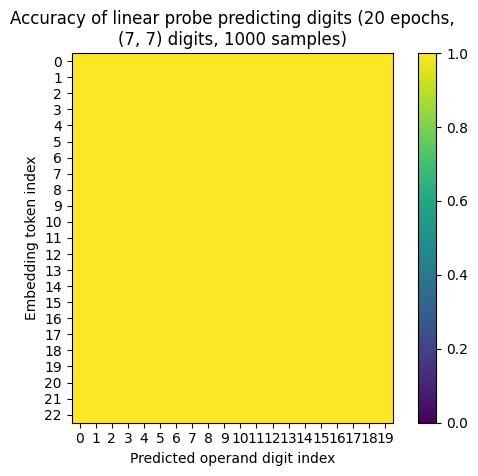

['\n$0099991125+0028566498', '\n$0085500639+0073682212', '\n$0080859018+0068539609']
targets: torch.Size([1000, 20]) torch.int64
embeddings: torch.Size([1000, 23, 384]) torch.float32


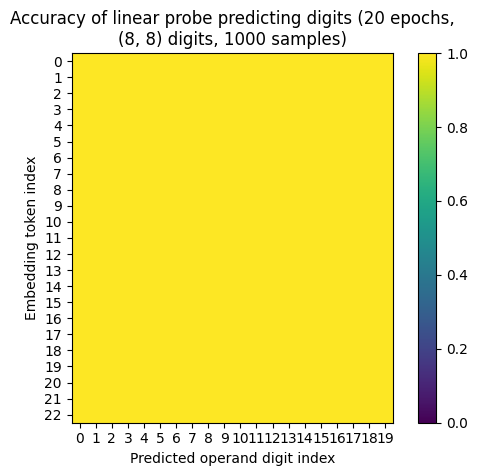

['\n$0936792305+0226685939', '\n$0718521364+0610240218', '\n$0142652808+0391736418']
targets: torch.Size([1000, 20]) torch.int64
embeddings: torch.Size([1000, 23, 384]) torch.float32


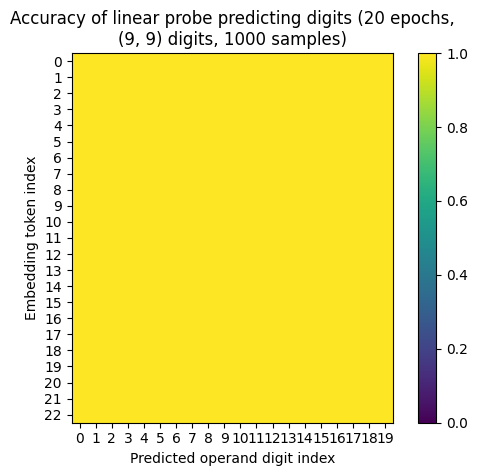

['\n$6242074724+5098988902', '\n$8256334358+1052258417', '\n$9473577979+2138871853']
targets: torch.Size([1000, 20]) torch.int64
embeddings: torch.Size([1000, 23, 384]) torch.float32


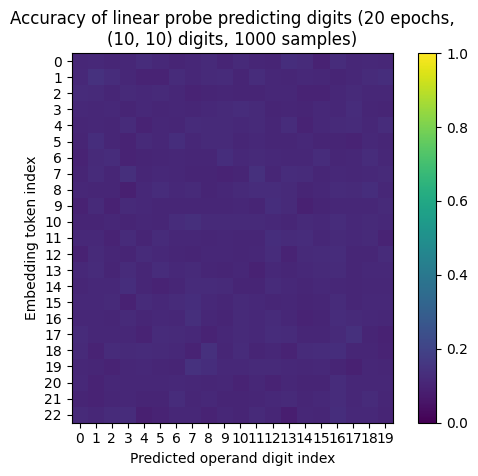

['\n$0327537524+5629384425', '\n$0401284093+2804101364', '\n$0712806539+4499390672']
targets: torch.Size([1000, 20]) torch.int64
embeddings: torch.Size([1000, 23, 384]) torch.float32


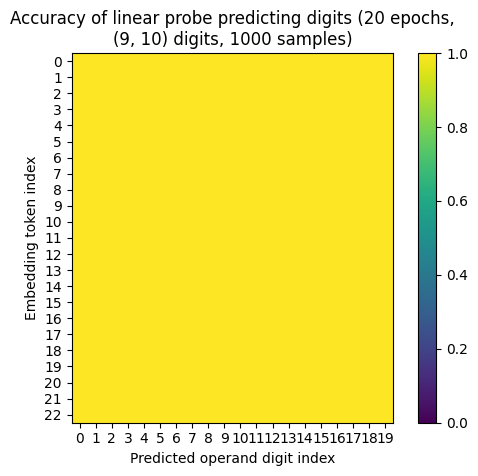

['\n$4324468107+0795902363', '\n$8882345986+0137159941', '\n$9231874990+0899674261']
targets: torch.Size([1000, 20]) torch.int64
embeddings: torch.Size([1000, 23, 384]) torch.float32


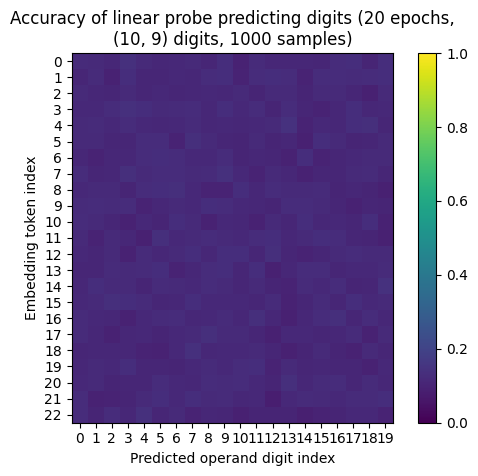

['\n$0000029177+4853885769', '\n$0000035744+5749672809', '\n$0000026623+8725316833']
targets: torch.Size([1000, 20]) torch.int64
embeddings: torch.Size([1000, 23, 384]) torch.float32


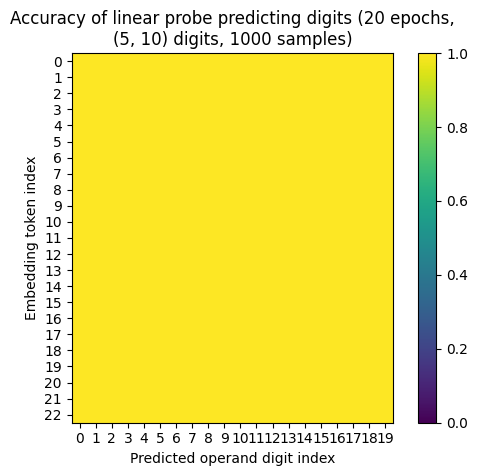

['\n$5420357090+0000090819', '\n$7077171820+0000027580', '\n$7333337531+0000064819']
targets: torch.Size([1000, 20]) torch.int64
embeddings: torch.Size([1000, 23, 384]) torch.float32


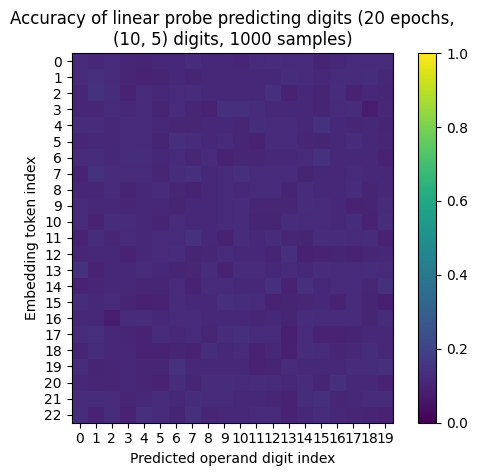

In [413]:
kwargs = dict(n_samples=1000, pad_zeros=10, pad_ans_zeros=11)

_, weights_7 = compute_and_plot_acc_matrix(n_digits=7, **kwargs)
_, weights_8 = compute_and_plot_acc_matrix(n_digits=8, **kwargs)
_, weights_9 = compute_and_plot_acc_matrix(n_digits=9, **kwargs)
_, weights_10 = compute_and_plot_acc_matrix(n_digits=10, **kwargs)
_, weights_9_10 = compute_and_plot_acc_matrix(n_digits=(9, 10), **kwargs)
_, weights_10_9 = compute_and_plot_acc_matrix(n_digits=(10, 9), **kwargs)
_, weights_5_10 = compute_and_plot_acc_matrix(n_digits=(5, 10), **kwargs)
_, weights_10_5 = compute_and_plot_acc_matrix(n_digits=(10, 5), **kwargs)
_, weights_pad11_10 = compute_and_plot_acc_matrix(
    n_digits=(10, 10),
    **kwargs,
    pad_zeros=11,
)

We can extract all operands in case of 7x7, 8x8 or 9x9 digit operands, but none for 10x10 digit operands. Interestingly, operands are still linearly predictable in 5x10 and 9x10 cases, but not in 10x9 and 10x5, which hints at the importance of the first digit in the prompt (model representations are thrown off if it is non-zero). A non-zero first digit is not encountered during training, but interestingly it is not a problem for the second operand's first digit.